**Zusammenfassung**

* Ein Datensatz bestehend aus 12190 Deutsch-Rezepten, die aus dem Internet abgekratzt wurden, wird verwendet, um zu bestimmen, zu welcher Gruppe sie gemäß den Zutaten gehören.
* Da kein Etikett angegeben ist, sollten unbeaufsichtigte Lernmethoden verwendet werden.
* Zu Beginn werden die Daten gereinigt und vorverarbeitet, bevor die NLP-Technik über die Tf-IDF-Vektorisierung angewendet wird, um die Wichtigkeit der einzelnen Inhaltsstoffe für alle Beobachtungen im Datensatz zu ermitteln.
* Danach sollte die Dimensionsreduktion von einer höheren Dimension nach der Vektorisierung zu einer niedrigeren Dimension für das K-Means-Clustering und auch für das t-SNE-Diagramm zur Visualisierung der Cluster erfolgen.
* Interaktives Plotten über Plotly zur besseren Visualisierung der Plots.

**1.Importieren Sie die erforderlichen libraries**

In [1]:
import pandas as pd
import numpy as np
import json
import re
from nltk.tokenize import RegexpTokenizer, word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**2.Datensatz öffnen**

In [2]:
data = []
with open('../input/german-recipes-dataset/recipes.json') as f:
    for line in f:
        data.append(json.loads(line))

**3.Datensatz Lesen**

In [3]:
recipe = data[0]
df = pd.DataFrame(recipe)
df.head()

,Url,Instructions,Ingredients,Day,Name,Year,Month,Weekday
0,https://www.chefkoch.de/rezepte/185441079701305/,Die Eier hart kochen. Dann pellen und mit eine...,"[600 g Hackfleisch, halb und halb, 800 g Sauer...",1,Gebratener Hasenrücken,2009,January,Thursday
1,https://www.chefkoch.de/rezepte/2718181424631245/,Vorab folgende Bemerkung: Alle Mengen sind Cir...,"[1 kg Strauchtomate(n), 1 Gemüsezwiebel(n), 1 ...",1,Pilz Stroganoff,2017,July,Saturday
2,https://www.chefkoch.de/rezepte/46341015661368/,"Die Kirschen abtropfen lassen, dabei den Saft ...","[1 Glas Kirsche(n), 1 Pck. Vanillepuddingpulve...",1,Kaninchen a la Gioff,2007,January,Monday
3,https://www.chefkoch.de/rezepte/51051018014178/,"Den Spargel säubern, die holzigen Enden abschn...","[500 g Spargel, grüner, 300 ml Brühe oder Fond...",1,Spanisches Knoblauch-Kaninchen,2013,April,Monday
4,https://www.chefkoch.de/rezepte/1555771262860408/,Kohlrabi schälen und klein würfeln. Mit der Br...,"[250 g Kohlrabi, 150 ml Gemüsebrühe, 150 ml Mi...",1,Gnocchi - Hack - Pfanne mit Basilikum,2017,August,Tuesday


In [4]:
df.shape

(12190, 8)

**4.Datenbereinigung und vorverarbeitung**

In [5]:
df = df.drop_duplicates(['Name'],keep='first')
df.shape

(192, 8)

In [6]:
df = df.drop(['Day','Month','Url','Weekday','Year'],axis=1)
df.head()

,Instructions,Ingredients,Name
0,Die Eier hart kochen. Dann pellen und mit eine...,"[600 g Hackfleisch, halb und halb, 800 g Sauer...",Gebratener Hasenrücken
1,Vorab folgende Bemerkung: Alle Mengen sind Cir...,"[1 kg Strauchtomate(n), 1 Gemüsezwiebel(n), 1 ...",Pilz Stroganoff
2,"Die Kirschen abtropfen lassen, dabei den Saft ...","[1 Glas Kirsche(n), 1 Pck. Vanillepuddingpulve...",Kaninchen a la Gioff
3,"Den Spargel säubern, die holzigen Enden abschn...","[500 g Spargel, grüner, 300 ml Brühe oder Fond...",Spanisches Knoblauch-Kaninchen
4,Kohlrabi schälen und klein würfeln. Mit der Br...,"[250 g Kohlrabi, 150 ml Gemüsebrühe, 150 ml Mi...",Gnocchi - Hack - Pfanne mit Basilikum


In [7]:
df['Ingredients'] = df['Ingredients'].apply(lambda x: ' '.join(x))
df.head()

,Instructions,Ingredients,Name
0,Die Eier hart kochen. Dann pellen und mit eine...,"600 g Hackfleisch, halb und halb 800 g Sauerkr...",Gebratener Hasenrücken
1,Vorab folgende Bemerkung: Alle Mengen sind Cir...,1 kg Strauchtomate(n) 1 Gemüsezwiebel(n) 1 Sal...,Pilz Stroganoff
2,"Die Kirschen abtropfen lassen, dabei den Saft ...","1 Glas Kirsche(n) 1 Pck. Vanillepuddingpulver,...",Kaninchen a la Gioff
3,"Den Spargel säubern, die holzigen Enden abschn...","500 g Spargel, grüner 300 ml Brühe oder Fond (...",Spanisches Knoblauch-Kaninchen
4,Kohlrabi schälen und klein würfeln. Mit der Br...,250 g Kohlrabi 150 ml Gemüsebrühe 150 ml Milch...,Gnocchi - Hack - Pfanne mit Basilikum


**5.TOKENISIERUNG & VEKTORISIERUNG**

In [8]:
# Define a function to perform both stemming and tokenization
def tokenizer(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for text in sent_tokenize(text) for word in word_tokenize(text)]
    
       
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.match(r'[A-ZÄÖÜ][a-zäöüß]+', token)]
    
    return filtered_tokens

In [9]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer parameters for efficient processing of text

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer,lowercase=False)

In [10]:
# Fit and transform the tfidf_vectorizer with the "plot" of each movie to create a vector representation of the plot summaries

tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in df['Ingredients']])

print(tfidf_matrix.shape)

(192, 714)


**6.K Means Clustering**

Perform dimensional reduction before K Means Clustering

In [11]:
pca = PCA(n_components=5)
X = pca.fit_transform(tfidf_matrix.todense())

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


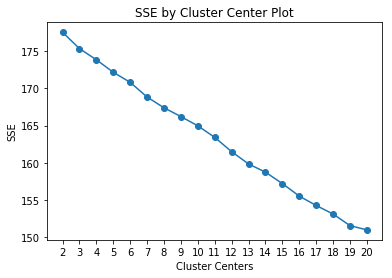

In [12]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(tfidf_matrix, 20)

From cluster plot, there seems to be no change in direction of plot, 'elbow' is not visible. Hence, a random guess would be used for fitting and prediction in K Means.

In [13]:
clusters = KMeans(n_clusters=5, random_state=20).fit_predict(tfidf_matrix)
df['clusters'] = clusters
df.head()

,Instructions,Ingredients,Name,clusters
0,Die Eier hart kochen. Dann pellen und mit eine...,"600 g Hackfleisch, halb und halb 800 g Sauerkr...",Gebratener Hasenrücken,4
1,Vorab folgende Bemerkung: Alle Mengen sind Cir...,1 kg Strauchtomate(n) 1 Gemüsezwiebel(n) 1 Sal...,Pilz Stroganoff,3
2,"Die Kirschen abtropfen lassen, dabei den Saft ...","1 Glas Kirsche(n) 1 Pck. Vanillepuddingpulver,...",Kaninchen a la Gioff,0
3,"Den Spargel säubern, die holzigen Enden abschn...","500 g Spargel, grüner 300 ml Brühe oder Fond (...",Spanisches Knoblauch-Kaninchen,0
4,Kohlrabi schälen und klein würfeln. Mit der Br...,250 g Kohlrabi 150 ml Gemüsebrühe 150 ml Milch...,Gnocchi - Hack - Pfanne mit Basilikum,2


In [14]:
#Plot K-means Clustering
trace_Kmeans = go.Scatter(x=X[:, 0], y= X[:, 1], mode="markers",
                    showlegend=False,
                    text = df['Name'],
                    hoverinfo = 'text',
                    marker=dict(
                            size=8,
                            color = clusters,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))
layout = dict(title = 'KMeans Clustering',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,
              width=600,
              height=600,
             )

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)
# fig1.append_trace(contour_list)
py.iplot(fig1, filename="svm")

**7.T-SNE**

In [15]:
tsne = TSNE()
tsne_results = tsne.fit_transform(tfidf_matrix.todense())

In [16]:
traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    mode = 'markers',
     text = df['Name'],
    hoverinfo = 'text',
    showlegend = True,
    marker = dict(
        size = 8,
        color = clusters,
        colorscale ='Portland',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= True,
              autosize=False,
              width=600,
              height=600,
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

**8.Sonstiges**

In [17]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tfidf_matrix, clusters, tfidf_vectorizer.get_feature_names(), 5)


Cluster 0
Butter,Salz,Milch,Mehl,Ei

Cluster 1
Bund,Ingwer,Schweinelende,Frühlingszwiebel,Sojasauce

Cluster 2
Sahne,Paprikapulver,Öl,Pfeffer,Zwiebel

Cluster 3
Tomate,Kräuter,Tomatenmark,Salz,Pfeffer

Cluster 4
Knoblauch,Zehe/n,Pfeffer,Zitrone,Olivenöl
